In [3]:
import numpy as np

import time
import torch
import torchvision

import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Plan

We're going to try to reproduce the paper: [Backpropagation Applied to Handwritten Zip Code Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf). It won't be exact. We'll make some changes when it makes the method easier to understand.

## Data

We're going to cover the MNIST dataset. It's a series of $28 \times 28$ black and white images of handwritten digits from 0 to 9.

## Model

The model we'll develop is from the paper above.
It is now called the LeNet model.

## Training

We'll use stochastic gradient descent and we'll talk about it in more detail when we get to this section.

# Data

MNIST stands for **m**odified **N**ational **I**nstitute of **S**tandards and **T**echnology database.
This is a database of handwritten digits from 0 to 9.
There are
- 60,000 training images with corresponding labels
- 10,000 test images with corresponding labels

The images are black and white, so have 1 color channel with size $28 \times 28$, that is 28 pixels high and 28 pixels wide.
The original dataset stored the images in a proprietary format, instead of the `.jpg` format.

Let's look at some examples of some images and labels!

In [4]:
mnist_norm = torchvision.datasets.MNIST(root='./data',
                                         transform=torchvision.transforms.ToTensor(),
                                         download=True)
mnist_norm_dl = torch.utils.data.DataLoader(mnist_norm, batch_size=len(mnist_norm))

In [5]:
for data, _ in mnist_norm_dl:
    mean = torch.mean(data, (0, 2, 3))
    std = torch.std(data, (0, 2, 3))

In [6]:
transforms = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=mean, std=std),
    ]
)

In [7]:
mnist_train = torchvision.datasets.MNIST(root='./data',
                                         transform=transforms,
                                         download=True)
mnist_test = torchvision.datasets.MNIST(root='./data',
                                        transform=transforms,
                                        download=True)

In [8]:
mnist_train_dl = torch.utils.data.DataLoader(mnist_train, batch_size=len(mnist_train), shuffle=True)
mnist_test_dl = torch.utils.data.DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=False)

In [9]:
images, labels = next(iter(mnist_train_dl))

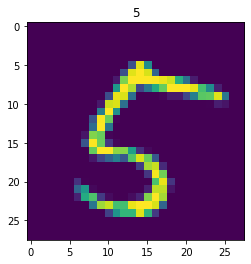

In [10]:
num = torch.randint(low=0, high=images.shape[0], size=(1,)).item()
plt.figure()
plt.imshow(images[num].squeeze(0))
plt.title(labels[num].item())
plt.show()

So, we loaded the data and we showed what some of the images look like.
Great, but how did we do it.
That's what we're going to go in more detail in a moment.

Pytorch is a great deep learning library, because it has a large amount of helper functions.
The first ones we'll go through is
`torch.utils.data.Dataset` and `torchvision.datasets.MNIST`.

`torch.utils.data.Dataset` is an **abstract class**.
All the other Pytorch dataset classes are subclasses of this class.
There are two methods that are the key to this class:
- `__getitem__`
- `__len__`

These are called **dunder** methods (dunder for double underscore).
The `__getitem__` is the method you call when you want to get another element from the dataset.
This method needs to be implemented when you create your own custom dataset class.

The other dunder method is `__len__`.
You call this method when you want to know how many elements are in your dataset.

We'll go through an example of this.
Recall that we called `torchvision.datasets.CIFAR10` the other day.
If we open up the [source code](https://pytorch.org/vision/stable/_modules/torchvision/datasets/cifar.html#CIFAR10), we'll see that it's a subclass of `VisionDataset`, which is a subclass of `torch.utils.data.Dataset`.
Our dunder methods `__getitem__` and `__len__` are not implemented.
If you try to call them you will get a `NotImplementedError`.

For `torchvision.datasets.CIFAR10`, the `__getitem__` is implemented as:

    def __getitem__(self, index: int) -> Tuple[Any, Any]:

        img, target = self.data[index], self.targets[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

The `CIFAR10` class has a class object called `data`.
This is where the data comes from and it's also where a lot of the complexity of getting the data is from.
The great thing about classes is that it doesn't matter if the difficulty is there!
We can still get the item!

Finally, the `__len__` is implemented as:

    def __len__(self) -> int:
        return len(self.data)

All datasets in Pytorch use this same format.
Pytorch also gives some useful helper classes, because the data is in a folder and the label of the data is the folder class.

Now, let's look at `torchvision.datasets.MNIST`:

In [11]:
torchvision.datasets.MNIST(root='./data',
                           train=True,
                           transform=None,
                           target_transform=None,
                           download=True
                          )

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

Let's go through the different parameters of the dataset and tell you what they mean:
- `root`: this is the location of the MNIST files or where you want these files to be downloaded.
- `train`: as Mason talked about last week, our datasets are split into a `train`, `test`, and `val` set. If we set `train=True`, then we select the `train` dataset.
- `transform`: this tells us how to transform the input portion of the dataset; in image classification, this would transform the image in almost any manner you want.
- `target_transform`: this transforms the label, which in image classification is number the model is trying to predict.
- `download`: we might already have the dataset on our computer, but if not, then we can set this to `True` and when we call the class, it will download the data along with preparing the data.

So, anything that is a subclass of `torch.utils.data.Dataset` is sufficient to train a neural network! We'll train a small model to show you that this works, but later, we'll learn why this is not the most efficient method.

In [12]:
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=torchvision.transforms.ToTensor())
test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=torchvision.transforms.ToTensor())

We now want to define the model:

In [13]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(1, 20, 3),
    torch.nn.ReLU(),
    torch.nn.Conv2d(20, 64, 3),
    torch.nn.ReLU(),
    torch.nn.Flatten(0, -1),
    torch.nn.Linear(36864, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 10),
    torch.nn.LogSoftmax(dim=0))

In [14]:
epochs = 1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = torch.nn.NLLLoss()
opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [15]:
def train(model, train_loader, criterion, opt, epochs=10):
    history = []
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print("Epoch | Batch | Time(s) | Loss")
    print("------------------------------")
    
    step = 0
    
    start = time.time()
    t = 0
    for epoch in range(epochs):        
        for i, (inputs, label) in enumerate(train_loader, 0):
            inputs = inputs.to(device)
            label = torch.tensor(label, device=device, dtype=torch.int64)
            
            opt.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, label)
            
            loss.backward()
            opt.step()
            
            step += 1
            history.append((step, loss))
            
            if i % 1000 == 999:
                t = time.time() - t - start
                print(f"{epoch + 1:5d} | {i+1:5d} | {int(t):8d} | {loss.item():.5f}")
    
    return history

In [16]:
history = train(model, train_dataset, criterion, opt, epochs=2)

Epoch | Batch | Time(s) | Loss
------------------------------
    1 |  1000 |       10 | 0.02356
    1 |  2000 |        5 | 0.39154
    1 |  3000 |       16 | 0.06587
    1 |  4000 |       11 | 0.00002
    1 |  5000 |       21 | 0.00206
    1 |  6000 |       16 | 0.00556
    1 |  7000 |       27 | 0.02085
    1 |  8000 |       22 | 0.00364
    1 |  9000 |       32 | 0.01517
    1 | 10000 |       27 | 0.01362
    1 | 11000 |       38 | 0.00003
    1 | 12000 |       33 | 0.00005
    1 | 13000 |       43 | 0.00153
    1 | 14000 |       38 | 0.06796
    1 | 15000 |       49 | 0.03803
    1 | 16000 |       44 | 0.01876
    1 | 17000 |       54 | 0.00063
    1 | 18000 |       49 | 0.00011
    1 | 19000 |       60 | -0.00000
    1 | 20000 |       55 | 0.00003
    1 | 21000 |       65 | 0.00308
    1 | 22000 |       60 | 0.00001
    1 | 23000 |       71 | 0.00008
    1 | 24000 |       66 | 0.00106
    1 | 25000 |       76 | 0.00004
    1 | 26000 |       72 | 0.00013
    1 | 27000 |       82 | 

What did we notice about that training?
It took a lot longer than the other training!
Part of this is because we're actually more concerned with training steps, so in this case, we did 120,000 training steps, whereas yesterday, we did 23 training steps!

In [17]:
def evaluate(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = inputs.to(device)
            label = torch.tensor(label, device=device, dtype=torch.int64)
            outputs = model(inputs)
            
            predicted = torch.argmax(outputs)
            total += 1
            correct += (predicted == label)
            
    print(f'Accuracy of the network on 10000 test images: {100 * correct // total} %')
    return 100 * correct // total

In [18]:
evaluate(model, test_dataset)

Accuracy of the network on 10000 test images: 98 %


/tmp/ipykernel_1303/3609566984.py:16: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  print(f'Accuracy of the network on 10000 test images: {100 * correct // total} %')
/tmp/ipykernel_1303/3609566984.py:17: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return 100 * correct // total


tensor(98, device='cuda:0')

Now we can talk about the `DataLoader` class in Pytorch.
This is a useful class, because it gives us a number of ways to control the computational and accelerator resources at our disposal.

Let's take a look at the class and the parameters:

    torch.utils.data.DataLoader(dataset, batch_size, shuffle, num_workers,
                                pin_memory, persistent_workers)

Let's go through these parameters:
- `dataset`: this is any sublcass of the `torch.utils.data.Dataset` class. The data which you will train your model on is loaded here.
- `batch_size`: this allows us to call several samples from the dataset at once. This is handy, because outside of model size, this will be the primary method we use to saturate the GPU.
- `shuffle`: this determines whether we want our dataset to be shuffled after every epoch.
- `num_workers`: this is just how many processes we use to load a batch of data to be trained.
- `pin_memory`: this keeps your tensors in memory, which reduces the amount of time the GPU needs to call it.
- `persistent_workers`: part of the CPU resources are used to collect elements from our dataset, transform them, and collate them. This is mainly done by the "workers". Setting this to `True` is a tradeoff for us. We would want to set this to `True` if the setup of our workers is a bigger drain on resources than the resources required to keep them alive.

Now, let's look at what our data looks like, when it's called.
First, we'll get data from the `torch.utils.data.Dataset` class and then we'll get data from the `torch.utils.data.DataLoader` class.

In [20]:
image, label = next(iter(train_dataset))

In [23]:
image.shape, label

(torch.Size([1, 28, 28]), 5)

As you can see, we get a tensor of shape (1, 28, 28) and just a python int.

In [24]:
dataloader = torch.utils.data.DataLoader(train_dataset,
                                         batch_size=4,
                                         shuffle=True)

In [25]:
image, label = next(iter(dataloader))

In [26]:
image.shape, label.shape

(torch.Size([4, 1, 28, 28]), torch.Size([4]))

We see that we get 4 images and 4 labels!

We'll cover more datasets, such as:
- CIFAR100
- Fashion MNIST
- EMNIST
- ImageNet
- Kuzushiji MNIST
- Imagenette
- Oracle MNIST
- MS COCO
- PASCAL VOC
- Objects365

and well cover the `torch.tensor` class in more detail!